In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold


In [2]:
df = pd.read_csv('waited estim.csv')

In [3]:
df.head()

,Queue Number,Patient Name,Age,Gender,Contact Number,Consultation Type,Doctor Name,Department,Arrival Time,Expected Wait Time
0,1,Tamar Cunradi,33,Female,141-199-9322,Specialist Consultation,Patrizio Wilkowski,Pediatrics,8/16/2022 09:06:19,108
1,2,Herrick Duff,0,Female,937-633-5201,Emergency,Mignon Blakiston,Otolaryngology,2/28/2022 00:47:34,198
2,3,Aurelea Dennert,3,Female,794-651-0555,Emergency,Tamarah Aronowitz,General Medicine,8/12/2022 11:01:16,199
3,4,Haydon Skirving,68,Other,316-555-8811,General Consultation,Krishnah Shipsey,Neurology,10/29/2022 16:49:48,166
4,5,Welby Boak,65,Female,479-762-6731,Emergency,Tabor Doerling,General Medicine,8/6/2022 21:59:39,14


In [4]:
df.describe()

,Queue Number,Age,Expected Wait Time
count,1000.000000,1000.000000,1000.000000
mean,500.500000,59.173000,120.675000
std,288.819436,34.623227,69.310037
min,1.000000,0.000000,0.000000
25%,250.750000,30.000000,63.000000
50%,500.500000,60.000000,121.000000
75%,750.250000,89.000000,180.000000
max,1000.000000,120.000000,240.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Queue Number        1000 non-null   int64 
 1   Patient Name        1000 non-null   object
 2   Age                 1000 non-null   int64 
 3   Gender              1000 non-null   object
 4   Contact Number      1000 non-null   object
 5   Consultation Type   1000 non-null   object
 6   Doctor Name         1000 non-null   object
 7   Department          1000 non-null   object
 8   Arrival Time        1000 non-null   object
 9   Expected Wait Time  1000 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 78.3+ KB


In [6]:
df.isnull().sum()

Queue Number          0
Patient Name          0
Age                   0
Gender                0
Contact Number        0
Consultation Type     0
Doctor Name           0
Department            0
Arrival Time          0
Expected Wait Time    0
dtype: int64

In [7]:
print(f"\nNumber of duplicate rows: {len(df) - len(df.drop_duplicates())}")


Number of duplicate rows: 0


In [8]:
# Step 1: Handle Age = 0 Cases
age_medians = df.groupby("Department")["Age"].median()
df.loc[df["Age"] == 0, "Age"] = df["Department"].map(age_medians)

/var/folders/xj/k3fw2zq952912hsnf6hpngx40000gn/T/ipykernel_54744/4050318106.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[58.  61.  59.  61.  49.  49.  61.  61.5 63. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df["Age"] == 0, "Age"] = df["Department"].map(age_medians)


/var/folders/xj/k3fw2zq952912hsnf6hpngx40000gn/T/ipykernel_54744/1989612337.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Department"], order=df["Department"].value_counts().index, palette="viridis", ax=axes[1, 1])
/var/folders/xj/k3fw2zq952912hsnf6hpngx40000gn/T/ipykernel_54744/1989612337.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Gender"], palette="coolwarm", ax=axes[2, 0])
/var/folders/xj/k3fw2zq952912hsnf6hpngx40000gn/T/ipykernel_54744/1989612337.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df

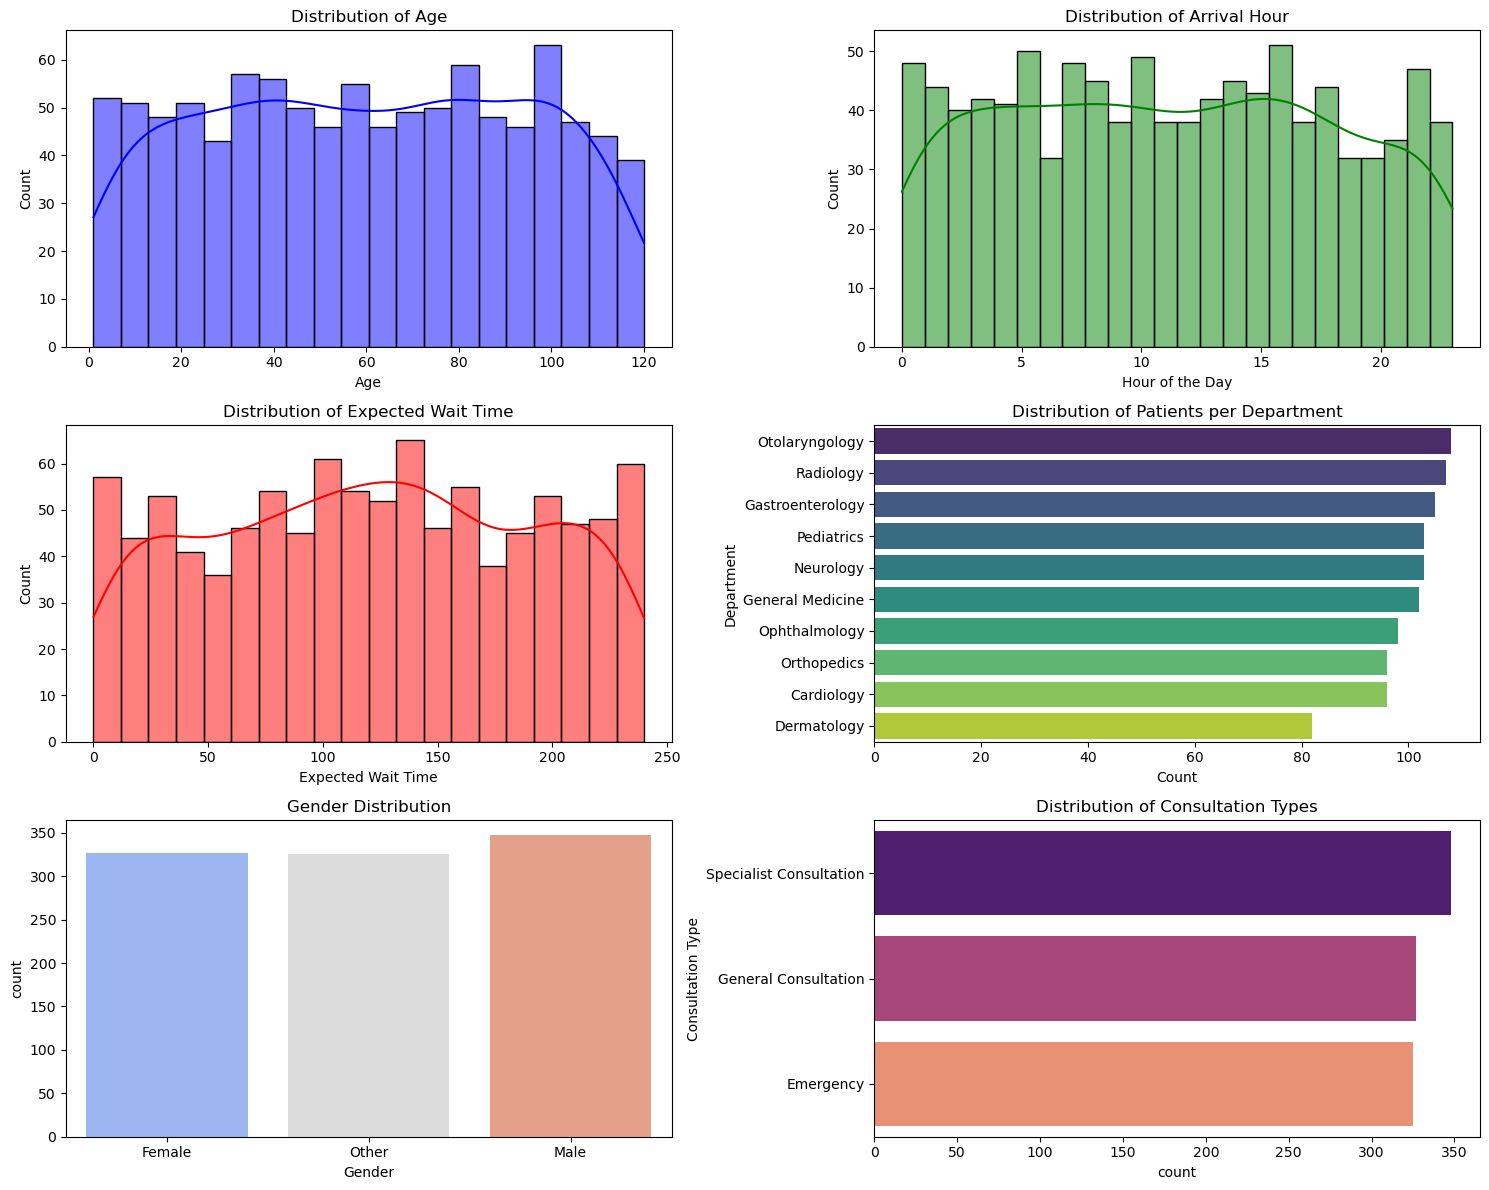

In [9]:
# EDA - Distribution Analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

sns.histplot(df["Age"], bins=20, kde=True, color="blue", ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Age")

sns.histplot(pd.to_datetime(df["Arrival Time"]).dt.hour, bins=24, kde=True, color="green", ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Arrival Hour")
axes[0, 1].set_xlabel("Hour of the Day")

sns.histplot(df["Expected Wait Time"], bins=20, kde=True, color="red", ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Expected Wait Time")

sns.countplot(y=df["Department"], order=df["Department"].value_counts().index, palette="viridis", ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Patients per Department")
axes[1, 1].set_xlabel("Count")

# Categorical Variable Analysis
sns.countplot(x=df["Gender"], palette="coolwarm", ax=axes[2, 0])
axes[2, 0].set_title("Gender Distribution")

sns.countplot(y=df["Consultation Type"], order=df["Consultation Type"].value_counts().index, palette="magma", ax=axes[2, 1])
axes[2, 1].set_title("Distribution of Consultation Types")

plt.tight_layout()
plt.show()

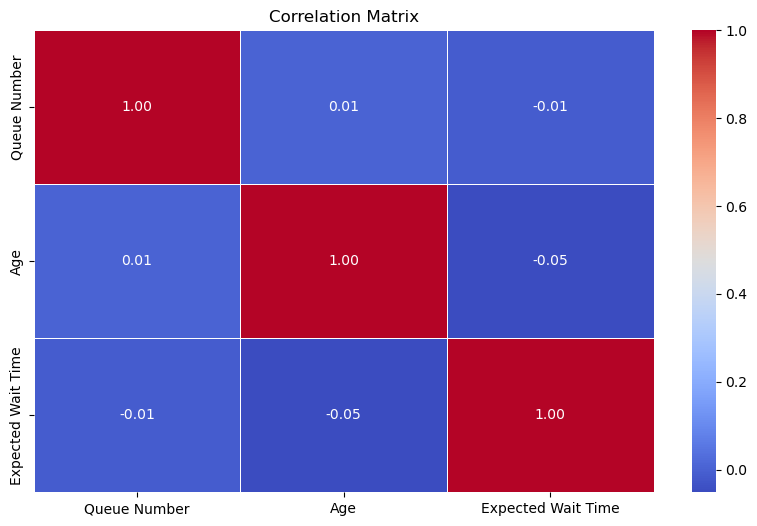

/var/folders/xj/k3fw2zq952912hsnf6hpngx40000gn/T/ipykernel_54744/64888905.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Department", y="Expected Wait Time", data=df, palette="Set2")


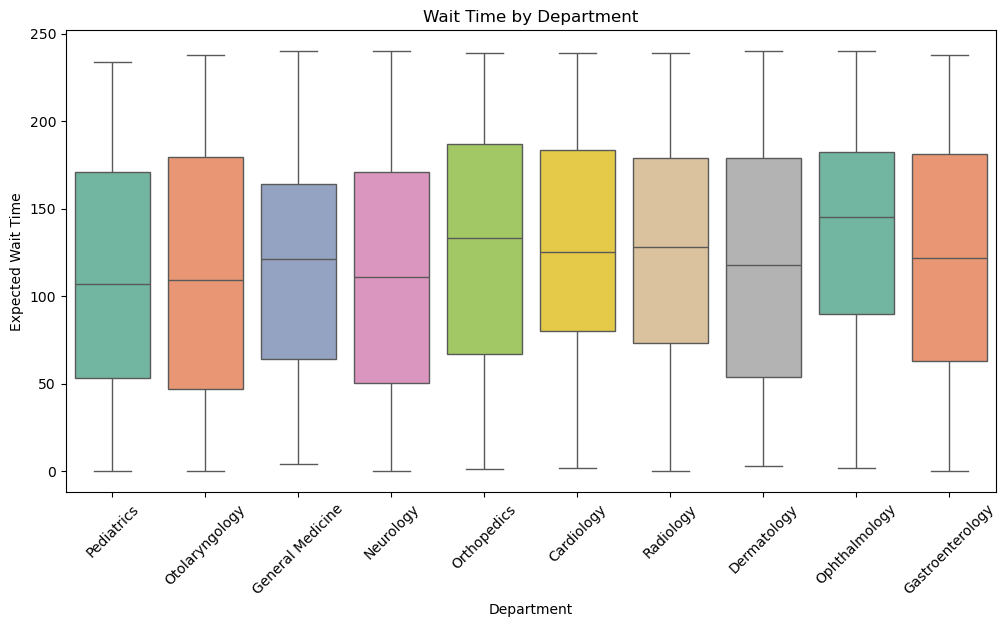

In [10]:
# Correlation Analysis
plt.figure(figsize=(10, 6))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Boxplot Relationship Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x="Department", y="Expected Wait Time", data=df, palette="Set2")
plt.xticks(rotation=45)
plt.title("Wait Time by Department")
plt.show()


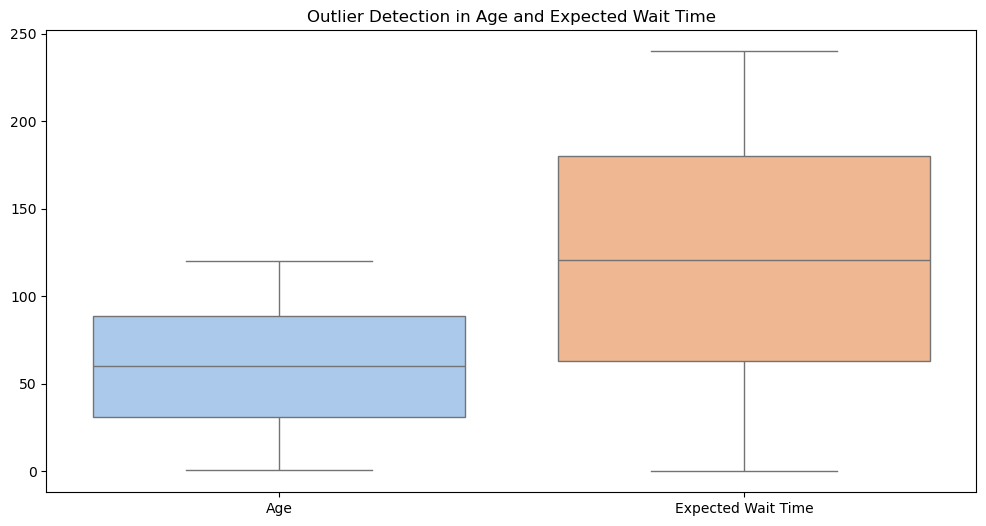


Outlier Count per Numeric Column:
Queue Number          0
Age                   0
Expected Wait Time    0
dtype: int64


In [11]:
# Outlier Detection using Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["Age", "Expected Wait Time"]], palette="pastel")
plt.title("Outlier Detection in Age and Expected Wait Time")
plt.show()

# Outlier Detection using IQR
numeric_cols = df.select_dtypes(include=[np.number])
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric_cols < (Q1 - 1.5 * IQR)) | (numeric_cols > (Q3 + 1.5 * IQR))).sum()
print("\nOutlier Count per Numeric Column:")
print(outliers)


In [12]:
# Step 2: Drop Irrelevant Columns
columns_to_drop = ["Patient Name", "Queue Number"]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)


In [13]:
# Step 3: Convert Arrival Time to Hour if column exists
if "Arrival Time" in df.columns:
    df["Arrival Hour"] = pd.to_datetime(df["Arrival Time"], errors='coerce').dt.hour
    df.drop(columns=["Arrival Time"], inplace=True)

In [14]:
# Step 4: Feature Engineering - Create Interaction Features
df["Age_Wait_Interaction"] = df["Age"] * df["Expected Wait Time"]

In [15]:
# Step 5: Define Features and Target
X = df.drop(columns=["Expected Wait Time"])
y = df["Expected Wait Time"]

In [16]:
# Step 6: Identify Numerical and Categorical Columns
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()


In [17]:
# Step 7: Data Preprocessing Pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features)
])


In [18]:
# Step 8: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Step 9: Model Benchmarking
def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}


In [20]:
results = {}
for name, model in models.items():
    mae, mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {"MAE": mae, "MSE": mse, "R2": r2}

# Step 10: Display Benchmark Results
results_df = pd.DataFrame(results).T
print("Model Benchmarking Results:")
print(results_df.sort_values(by="MAE"))


Model Benchmarking Results:
                         MAE          MSE        R2
Random Forest       6.883550   159.612408  0.966718
Gradient Boosting  10.256098   242.416812  0.949452
Decision Tree      12.030000   395.620000  0.917507
Linear Regression  25.068001  1217.585881  0.746115


In [21]:
# Step 11: Model Benchmarking with Cross-Validation
def evaluate_model_cv(model, X, y, cv=15):
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
    return np.mean(scores), np.std(scores)

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

cv_results = {}
for name, model in models.items():
    mean_r2, std_r2 = evaluate_model_cv(model, X_train, y_train, cv=5)
    cv_results[name] = {"Mean R2": mean_r2, "Std R2": std_r2}

In [22]:
# Step 10: Display Cross-Validation Results
cv_results_df = pd.DataFrame(cv_results).T
print("Cross-Validation Results:")
print(cv_results_df.sort_values(by="Mean R2", ascending=False))


Cross-Validation Results:
                    Mean R2    Std R2
Random Forest      0.962919  0.018633
Gradient Boosting  0.945593  0.020523
Decision Tree      0.919257  0.013484
Linear Regression  0.756942  0.022460


In [23]:
# Step 12: Hyperparameter Tuning with GridSearchCV
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 10]
}

best_models = {}

for model_name, model, param_grid in zip(["Random Forest", "Gradient Boosting"],
                                          [RandomForestRegressor(random_state=42), GradientBoostingRegressor(random_state=42)],
                                          [param_grid_rf, param_grid_gb]):
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")

Best Parameters for Random Forest: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best Parameters for Gradient Boosting: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}


In [24]:
# Step 13: Evaluate Best Model on Test Set
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    print(f"{model_name} Test Performance:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"R2 Score: {r2_score(y_test, y_pred)}\n")

Random Forest Test Performance:
MAE: 6.550705724183222
MSE: 153.8464585517076
R2 Score: 0.9679206784596545

Gradient Boosting Test Performance:
MAE: 5.617874970490644
MSE: 89.82147702244565
R2 Score: 0.98127085881757



In [25]:
import joblib

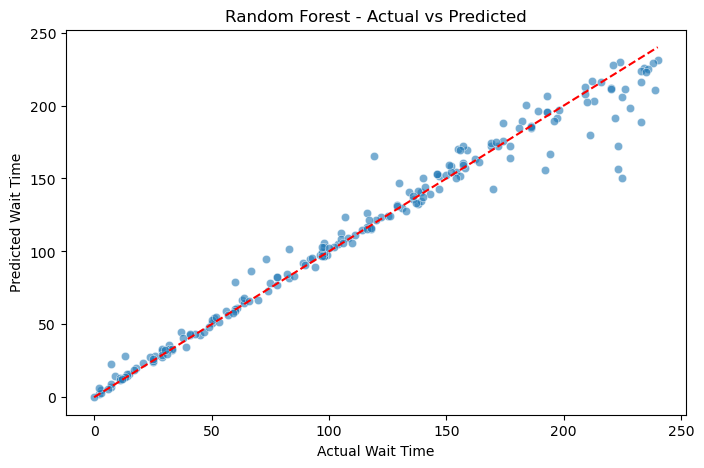

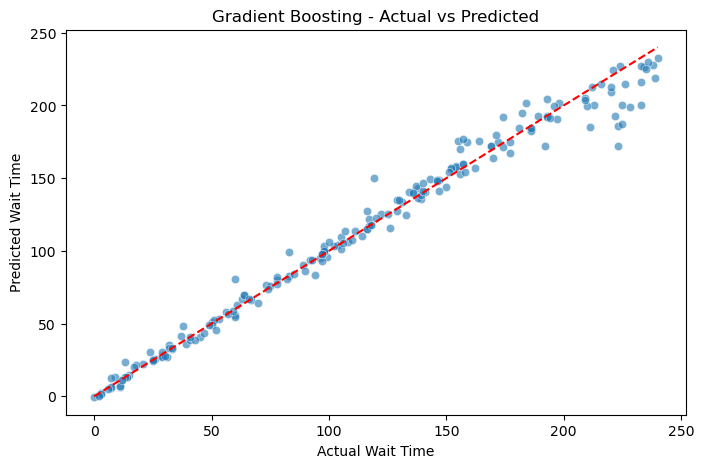

In [26]:
# Step 14: Visualization
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Wait Time")
    plt.ylabel("Predicted Wait Time")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.show()

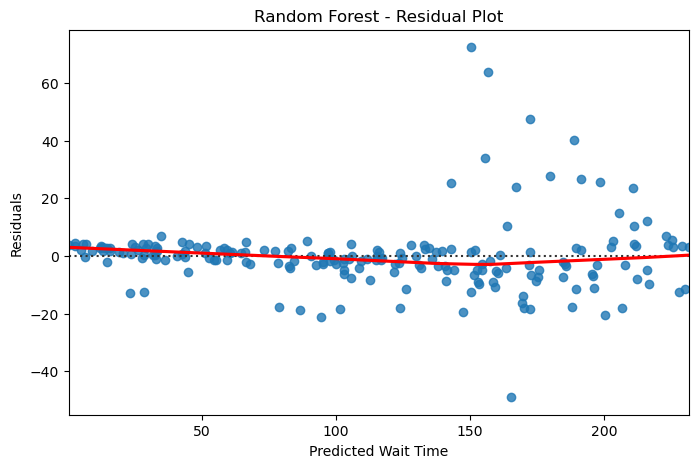

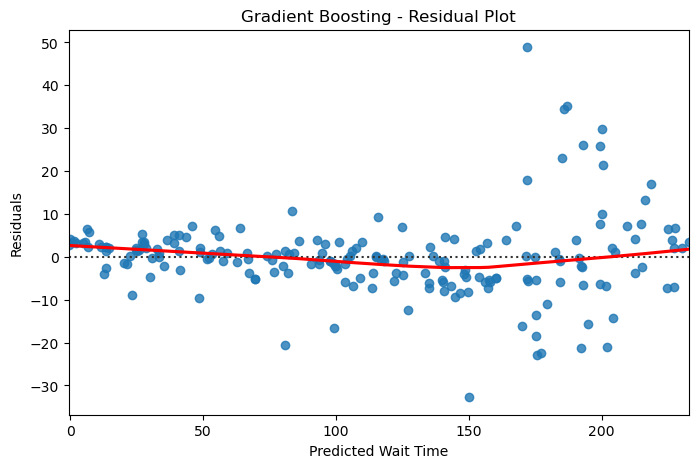

In [27]:
for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    plt.figure(figsize=(8, 5))
    sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, line_kws={"color": "red"})
    plt.xlabel("Predicted Wait Time")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} - Residual Plot")
    plt.show()

In [29]:
# Step 15: Save the best model
joblib.dump(best_models["Gradient Boosting"], "/Users/helvila/Downloads/self-project/Jan-Feb/best_model.pkl")

['/Users/helvila/Downloads/self-project/Jan-Feb/best_model.pkl']